# Primeiros passos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intrig-unicamp/hackathon5G/blob/main/challenges/get-started.ipynb)

Esse Notebook contém breves casos de uso de aplicações de métodos de aprendizado de máquina nos conjuntos de dados disponibilizados para demonstrar os primeiros passos para se abordar os desafios propostos.

## Instalação das dependências

Instalar as dependências no ambiente adequado (pip ou Anaconda).

In [1]:
try:
    import google.colab as _
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install pyshark pandas numpy seaborn scikit-learn plotly -q
else:
    !conda install pyshark pandas numpy seaborn scikit-learn plotly -qy --freeze-installed

In [2]:
%%bash

if type tshark >/dev/null 2>&1; then
    echo "tshask already installed"

elif type nix-env >/dev/null 2>&1; then
    nix-env -iA nixpkgs.tshark

elif type apt-get >/dev/null 2>&1; then
    apt-get -q install tshark

elif type yum >/dev/null 2>&1; then
    yum install tshark -q -y

elif type apk >/dev/null 2>&1; then
    apk add -q tshark

elif type pacman >/dev/null 2>&1; then
    pacman -S tshark

fi

tshask already installed


## Obtendo arquivos de dados

Baixamos os arquivos caso o Notebook esteja sendo executado no ambiente do Google Colab. A variável de prefixo do caminho dos arquivos é definida de acordo.

In [3]:
if IN_COLAB:
    !git clone --depth=1 https://github.com/intrig-unicamp/hackathon5G.git hackathon5G

DATA_PATH_PREFIX = './hackathon5G/datasets' if IN_COLAB else '../datasets'

## Importando dependências globais

In [4]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances

import pyshark

# https://github.com/KimiNewt/pyshark/issues/360#issuecomment-700425352
import nest_asyncio
nest_asyncio.apply()

import os
from datetime import datetime
from math import radians
import json
from urllib.parse import urlparse, parse_qsl

pd.set_option('display.max_columns', None)

## Carregando os dados

### G-NetTrack

In [5]:
GNETTRACKPRO_PATH = f'{DATA_PATH_PREFIX}/g-nettrack-pro'

datasets = [ file for file in os.listdir(GNETTRACKPRO_PATH) if file.endswith('.txt') ]

gnetDf = pd.concat([ pd.read_csv(f'{GNETTRACKPRO_PATH}/{dataset}', sep='\t', low_memory=False, on_bad_lines='warn') for dataset in datasets ]).copy()
gnetDf.drop(gnetDf.loc[gnetDf.Timestamp == 'Timestamp'].index, inplace=True)
gnetDf.Timestamp = pd.to_datetime(gnetDf.Timestamp, format='%Y.%m.%d_%H.%M.%S')
gnetDf['Timestamp_seconds'] = gnetDf.Timestamp.astype(int) // 10**9
gnetDf.sort_values('Timestamp', inplace=True, ignore_index=True)
gnetDf.replace({
    'Altitude': { '--': np.nan },
    'CHARGING': { 'true': True, 'false': False },
    **{ k: { '--': np.nan } for k in ['Longitude', 'Latitude', 'NetworkTech', 'Accuracy'] },
    **{ k: { '-': np.nan } for k in ['CQI', 'SNR', 'Qual', 'LTERSSI'] },
}, inplace=True)
gnetDf = gnetDf.astype({
    **{ k: 'string' for k in ['NetworkTech', 'NetworkMode', 'Location', 'State', 'EVENT', 'CGI', 'Node', 'CellID', 'LAC', 'Operatorname', 'Operator', 'IP'] },
    **{ k: np.float64 for k in ['Longitude', 'Latitude', 'Speed', 'Accuracy', 'SNR', 'Level', 'Qual', 'CQI', 'LTERSSI', 'ARFCN', 'DL_bitrate', 'UL_bitrate', 'PSC', 'Altitude', 'Height'] },
    **{ k: np.int32 for k in ['BATTERY'] },
})
gnetDf.replace({
    'Altitude': { 0: np.nan },
    'Height': { 0: np.nan, -10000: np.nan },
    'Speed': { -99: np.nan },
}, inplace=True)
gnetDf

Skipping line 1291: expected 260 fields, saw 390
Skipping line 1292: expected 260 fields, saw 390
Skipping line 1293: expected 260 fields, saw 390
Skipping line 1294: expected 260 fields, saw 390
Skipping line 1295: expected 260 fields, saw 390
Skipping line 1296: expected 260 fields, saw 390
Skipping line 1297: expected 260 fields, saw 390
Skipping line 1298: expected 260 fields, saw 390
Skipping line 1299: expected 260 fields, saw 390
Skipping line 1300: expected 260 fields, saw 390
Skipping line 1301: expected 260 fields, saw 390
Skipping line 1302: expected 260 fields, saw 390
Skipping line 1303: expected 260 fields, saw 390
Skipping line 1304: expected 260 fields, saw 390
Skipping line 1305: expected 260 fields, saw 390
Skipping line 1306: expected 260 fields, saw 390
Skipping line 1307: expected 260 fields, saw 390
Skipping line 1308: expected 260 fields, saw 390
Skipping line 1309: expected 260 fields, saw 390
Skipping line 1310: expected 260 fields, saw 390
Skipping line 1311: 

Timestamp  Longitude   Latitude  Speed Operatorname Operator   
0     2023-01-21 14:44:46        NaN        NaN    NaN     CLARO_BR    72405  \
1     2023-01-21 14:44:46        NaN        NaN    NaN     CLARO_BR    72405   
2     2023-01-21 14:44:47        NaN        NaN    NaN     CLARO_BR    72405   
3     2023-01-21 14:44:48        NaN        NaN    NaN     CLARO_BR    72405   
4     2023-01-21 14:44:49        NaN        NaN    NaN     CLARO_BR    72405   
...                   ...        ...        ...    ...          ...      ...   
18341 2023-01-22 22:31:02 -46.728399 -23.595755    0.0     CLARO_BR    72405   
18342 2023-01-22 22:31:03 -46.728399 -23.595755    0.0     CLARO_BR    72405   
18343 2023-01-22 22:31:04 -46.728399 -23.595755    0.0     CLARO_BR    72405   
18344 2023-01-22 22:31:05 -46.728399 -23.595755    0.0     CLARO_BR    72405   
18345 2023-01-22 22:31:05 -46.728399 -23.595755    0.0     CLARO_BR    72405   

                   CGI Cellname    Node CellID    LAC NetworkTech NetworkMode   
0      724056481100018      NaN  113726     18  64811          4G         LTE  \
1      724056481100018      NaN  113726     18  64811          4G         LTE   
2      724056481100018      NaN  113726     18  64811          4G         LTE   
3      724056481100017      NaN  113726     17  64811          4G         LTE   
4      724056481100017      NaN  113726     17  64811          4G         LTE   
...                ...      ...     ...    ...    ...         ...         ...   
18341  724054571100003      NaN  111825      3  45711          4G         LTE   
18342  724054571100003      NaN  111825      3  45711          4G         LTE   
18343  724054571100003      NaN  111825      3  45711          4G         LTE   
18344  724054571100003      NaN  111825      3  45711          4G         LTE   
18345  724054571100003      NaN  111825      3  45711          4G         LTE   

       Level  Qual   SNR   CQI  LTERSSI   ARFCN  DL_bitrate  UL_bitrate   
0     -110.0  -8.0  16.0  14.0    -61.0  1400.0        25.0        29.0  \
1     -112.0  -8.0  17.0  14.0    -65.0  1400.0       119.0        53.0   
2     -112.0  -8.0  17.0  14.0    -65.0  1400.0        15.0         2.0   
3     -109.0  -8.0   4.0   6.0    -59.0  1400.0         0.0         0.0   
4     -109.0  -8.0   4.0   6.0    -59.0  1400.0         0.0         0.0   
...      ...   ...   ...   ...      ...     ...         ...         ...   
18341 -108.0 -17.0  -2.0  10.0   -109.0  2950.0        53.0        56.0   
18342 -108.0 -17.0  -2.0  10.0   -109.0  2950.0        43.0        29.0   
18343 -107.0 -16.0  -2.0  10.0   -105.0  2950.0        70.0       158.0   
18344 -107.0 -16.0  -2.0  10.0   -105.0  2950.0      3309.0       144.0   
18345 -107.0 -16.0  -2.0  10.0   -105.0  2950.0      3309.0       144.0   

         PSC  Altitude  Height  Accuracy Location State PINGAVG PINGMIN   
0      111.0       NaN     NaN       NaN      NaN     D     NaN     NaN  \
1      111.0       NaN     NaN       NaN      NaN     D     NaN     NaN   
2      111.0       NaN     NaN       NaN      NaN     D     NaN     NaN   
3      103.0       NaN     NaN       NaN      NaN     D     NaN     NaN   
4      103.0       NaN     NaN       NaN      NaN     I     NaN     NaN   
...      ...       ...     ...       ...      ...   ...     ...     ...   
18341  305.0     779.0   779.0       4.0        G     D     NaN     NaN   
18342  305.0     779.0   779.0       4.0        G     D     NaN     NaN   
18343  305.0     779.0   779.0       4.0        G     D     NaN     NaN   
18344  305.0     779.0   779.0       4.0        G     D     NaN     NaN   
18345  305.0     779.0   779.0       4.0        G     D     NaN     NaN   

      PINGMAX PINGSTDEV PINGLOSS TESTDOWNLINK TESTUPLINK TESTDOWNLINKMAX   
0         NaN       NaN      NaN          NaN        NaN             NaN  \
1         NaN       NaN      NaN          NaN        NaN             NaN   
2         NaN       NaN      NaN          NaN       

# Exemplos de casos de uso

## Predição de qualidade de sinal

Para exemplicar uma simples implementação de predição de qualidade de sinal, vamos usar um regressor para predizer a métrica `Qual` do conjunto de dados `g-nettrack` com base nos atributos `Longitude`, `Latitude` e `Altitude`.

Segundo o [manual do G-NetTrack](https://gyokovsolutions.com/manual-g-nettrack/#:~:text=Qual%20%E2%80%93%20RxQual%20on%202G%2C%20ECNO%20on%203G%2C%20RSRQ%20on%204G%20and%205G), a métrica `Qual` representa o nível de interferência no sinal RX do dispositivo do usuário.

In [6]:
# removendo entradas com valores nulos
df = gnetDf[['Longitude', 'Latitude', 'Altitude', 'Qual']].dropna()

# selecionando os atributos (x) e os rótulos (y) para a predição
x = df.reindex(columns=['Longitude', 'Latitude', 'Altitude'])
y = df.reindex(columns=['Qual'])

display(Markdown('### Atributos'))
display(x)

display(Markdown('### Rótulos'))
display(y)

### Atributos

Longitude   Latitude  Altitude
675   -46.662583 -23.555975     831.0
676   -46.662583 -23.555975     831.0
677   -46.662222 -23.555683     820.0
678   -46.662222 -23.555683     820.0
679   -46.662583 -23.555975     831.0
...          ...        ...       ...
18341 -46.728399 -23.595755     779.0
18342 -46.728399 -23.595755     779.0
18343 -46.728399 -23.595755     779.0
18344 -46.728399 -23.595755     779.0
18345 -46.728399 -23.595755     779.0

[17577 rows x 3 columns]

### Rótulos

Qual
675   -12.0
676   -12.0
677   -12.0
678   -12.0
679   -12.0
...     ...
18341 -17.0
18342 -17.0
18343 -16.0
18344 -16.0
18345 -16.0

[17577 rows x 1 columns]

Para predizer a métrica `Qual` a partir dos atributos de coordenadas geográficas do dispositivo, utilizaremos o algoritmo de regressão _Random Forest_. Esse algoritmo pode ser usado para predizer a métrica `Qual` porque ela é um valor numérico contínuo.

O código abaixo exemplifica como subdividir o conjunto de dados em subconjuntos de treinamento e teste, como utilizá-los para treinar e avaliar o desempenho do regressor e, por fim, como identificar a importância de cada atributo para a predição da qualidade de sinal da rede (`Qual`).

**Quantidade de amostras (embaralhadas)**

treinamento: 14061

teste: 3516

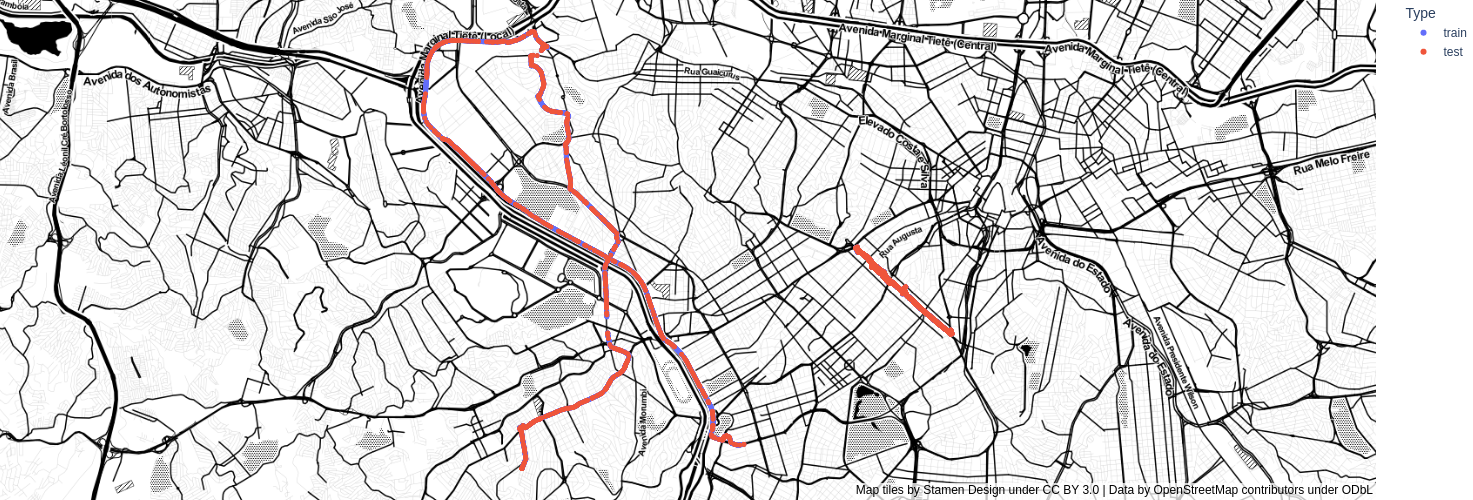

**Desempenho do regressor (R2 Score)**

treinamento: 0.8027946109736619

teste: 0.7616590194896662

**Nível de importância dos atributos para a predição da métrica `Qual`**

Longitude: 0.33

Latitude: 0.26

Altitude: 0.41

In [7]:
# importando as bibliotecas de apoio
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px

# 1. Subdvidindo o conjunto de dados entre os subconjuntos de treinamento e teste.
# notem que neste caso os dados não estão sendo tratados como uma série temporal,
# assim, podemos selecionar as amostras de treinamento e teste de forma aleatória
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

df_train = x_train.copy()
df_train['Type'] = 'train'

df_test = x_test.copy()
df_test['Type'] = 'test'

fig = px.scatter_mapbox(pd.concat([df_train, df_test]), lat='Latitude', lon='Longitude', color='Type',
                        size_max=20, zoom=11.8, width=1000, height=500,
                        center=dict(lon=(df.Longitude.min() + df.Longitude.max()) / 2, lat=(df.Latitude.min() + df.Latitude.max()) / 2))
fig.update_layout(mapbox=dict(style='stamen-toner'), margin=dict(l=0, r=0, t=0, b=0))

display(Markdown('**Quantidade de amostras (embaralhadas)**'))
display(Markdown(f'treinamento: {len(x_train)}'))
display(Markdown(f'teste: {len(x_test)}'))
display(fig)

# 2. Convertendo y para array 1D
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# 3. Treinando um regressor baseado em Random Forest
model = RandomForestRegressor(n_estimators=20, random_state=42).fit(x_train, y_train)

# 4. Avaliando o desempenho do regressor
display(Markdown('**Desempenho do regressor (R2 Score)**'))
display(Markdown(f'treinamento: {model.score(x_train, y_train)}'))
display(Markdown(f'teste: {model.score(x_test, y_test)}'))

# 5. Exibindo o nível de importância dos atributos selecionados para a predição de Qual
display(Markdown('**Nível de importância dos atributos para a predição da métrica `Qual`**'))

importances = list(model.feature_importances_)
for i in range(len(x.columns)):
    display(Markdown(f'{x.columns[i]}: {importances[i]:.2f}'))

Ainda que esta simples aplicação tenha proporcionado um resultado inicial promissor, notem que essa não é a resposta:

De forma que os conjuntos de treinamento e teste são separados de forma aleatória, o modelo acaba aprendendo a qualidade de sinal para coordenadas vizinhas, fazendo apenas a interpolação da métrica `Qual` entre coordenadas. Nesse cenário, não é possível fazer a predição para regiões onde não se fez uma coleta de dados.

Observe o que acontece se dividirmos o conjunto de dados sem realizar o passo de embaralhamento dos dados para simular a situação de predição para novas regiões:

**Quantidade de amostras (em ordem natural)**

treinamento: 14061

teste: 3516

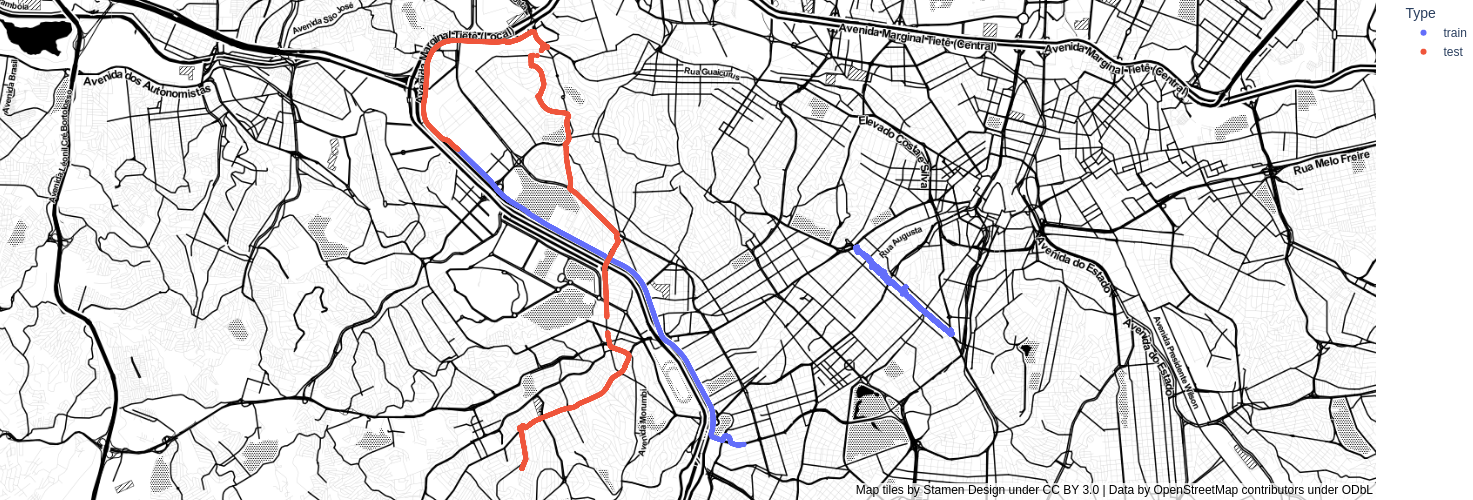

**Desempenho do regressor (R2 Score)**

treinamento: 0.7754141639255777

teste: -1.5018512743675045

**Nível de importância dos atributos para a predição da métrica `Qual`**

Longitude: 0.33

Latitude: 0.29

Altitude: 0.37

In [8]:
# 1. Subdvidindo o conjunto de dados entre os subconjuntos de treinamento e teste.
# notem que neste caso os dados não estão sendo tratados como uma série temporal,
# assim, podemos selecionar as amostras de treinamento e teste de forma determinística
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

df_train = x_train.copy()
df_train['Type'] = 'train'

df_test = x_test.copy()
df_test['Type'] = 'test'

fig = px.scatter_mapbox(pd.concat([df_train, df_test]), lat='Latitude', lon='Longitude', color='Type',
                        size_max=20, zoom=11.8, width=1000, height=500,
                        center=dict(lon=(df.Longitude.min() + df.Longitude.max()) / 2, lat=(df.Latitude.min() + df.Latitude.max()) / 2))
fig.update_layout(mapbox=dict(style='stamen-toner'), margin=dict(l=0, r=0, t=0, b=0))

display(Markdown('**Quantidade de amostras (em ordem natural)**'))
display(Markdown(f'treinamento: {len(x_train)}'))
display(Markdown(f'teste: {len(x_test)}'))
display(fig)

# 2. Convertendo y para array 1D
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# 3. Treinando um regressor baseado em Random Forest
model = RandomForestRegressor(n_estimators=20, random_state=42).fit(x_train, y_train)

# 4. Avaliando o desempenho do regressor
display(Markdown('**Desempenho do regressor (R2 Score)**'))
display(Markdown(f'treinamento: {model.score(x_train, y_train)}'))
display(Markdown(f'teste: {model.score(x_test, y_test)}'))

# 5. Exibindo o nível de importância dos atributos selecionados para a predição de Qual
display(Markdown('**Nível de importância dos atributos para a predição da métrica `Qual`**'))

importances = list(model.feature_importances_)
for i in range(len(x.columns)):
    display(Markdown(f'{x.columns[i]}: {importances[i]:.2f}'))

Veja como uma simples alteração na divisão dos conjuntos de treinamento e teste pode resultar em uma grande diferença na avaliação do modelo (como também pode revelar suas falhas conceituais).

Deste modo, as equipes devem testar novos tipos de representação de dados, incluindo a seleção e engenharia de atributos, novas proporções de divisão dos conjuntos de treinamento e teste, entre outras técnicas que podem ser determinantes para a predição da qualidade do sinal de forma assertiva.

A escolha do algoritmo e o ajuste adequado de seus hiperparâmetros também estão diretamente relacionados com o desempenho da predição.